# Utilizing Deep Learning for Drug lead optimization

In [ ]:
#@title  Importing Required Libraries
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib as mpl

import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 300
%matplotlib inline

from tensorflow import keras
import numpy as np
from sklearn.metrics import f1_score
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Input,GRU,UpSampling1D, Conv1D, RepeatVector, MaxPooling1D, Activation,BatchNormalization, LSTM,Embedding, Dense, TimeDistributed, Bidirectional,concatenate, Dropout, LSTM
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.layers import Convolution1D, SeparableConv1D, ConvLSTM1D, Lambda, GaussianNoise
#from keras.layers import  Dropout
from tensorflow.keras import backend  as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.python.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Flatten, Reshape
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import add
from tensorflow.keras import metrics

import pickle
import random

import tensorflow._api.v2.compat.v1 as tf

tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:

!git clone https://github.com/rajkumar1501/drug_analog_data.git
!pip install rdkit-pypi

Cloning into 'drug_analog_data'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (4/4), 4.48 MiB | 17.59 MiB/s, done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 51.3 MB/s eta 0:00:00


In [ ]:

def load_dataset(data_set):
    # creating cleaned input, output pairs

    # Vectorize the input and target languages



    # English sentences

    with open('/content/drug_analog_data/smiles_indexs.pkl','rb') as f:
        #DrugIndex = [drugIndex.ch2idx,inp_lang.indx2ch]
        DrugIndex = pickle.load(f)
    target_tensor = [[DrugIndex[0][s] for s in list(mol)] for  mol in data_set]
    # Spanish sentences
    input_tensor = [[DrugIndex[0][s] for s in list(mol)] for mol in data_set]

    #input_pred = [[targ_lang.ch2idx[s] for s in list(mol)] for  mol in data_set]

    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp = max([len(i) for i in data_set])
    max_length_tar = max([len(i) for i in data_set])

    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor,
                                                                 maxlen=100,
                                                                 padding='post',truncating='post')

       #input_pred = tf.keras.preprocessing.sequence.pad_sequences(input_pred,
                                                                 # maxlen=max_length_inp,
                                                                 # padding='post',truncating='post')
    return input_tensor, DrugIndex

#@title
maxlen = 100

def model(maxlen):
    input_1 = Input(shape=(maxlen,))
    layer_1 = Embedding(input_dim=45, output_dim=32, input_length=maxlen,name='Embedding')(input_1)

    layer_2 = LSTM(units=64, name = 'encoder_lstm',return_sequences=True)(layer_1)

    layer_3 = Dense(4, activation = 'relu',name='dense_1')(layer_2)
    #layer_3 = BatchNormalization(center=True,scale=True,name= 'batch')(layer_3)
    flatten = Flatten()(layer_3)
    layer_3 = Dense(100, activation = 'relu',name='dense_2')(flatten)
    layer_3 = BatchNormalization(center=True,scale=True,name= 'batch_b')(layer_3)





    encoder = Model(input_1, layer_3 )

    return encoder




vae_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
encoder = model(maxlen)




cc = keras.losses.CategoricalCrossentropy()

encoder.compile(loss= cc , optimizer=vae_optimizer, metrics=['categorical_accuracy'])
#model_2.load_weights('model_6_chemble_dense1_2.h5',by_name=True)
encoder.load_weights('/content/drug_analog_data/model_6_batch8192.h5',by_name=True)



#@title
maxlen = 100

def model(maxlen):
    input_1 = Input(shape=(maxlen,))
    layer_3 = Dense(200, activation = 'relu',name='dense_3')(input_1)

    layer_3 = Reshape((100, 2))(layer_3)


    layer_5 = TimeDistributed(Dense(64, activation="relu",name='decoder_2_0'),name = 'TD_3_0')(layer_3)
    layer_6 = LSTM(units=256,return_sequences=True,name='decoder_4_0')(layer_5)

    output = TimeDistributed(Dense(45, activation="softmax",name='final_0'),name='TD_4_0')(layer_6)
    model_2 = Model(input_1, output)

    return model_2


vae_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
decoder = model(maxlen)




cc = keras.losses.CategoricalCrossentropy()

decoder.compile(loss= cc , optimizer=vae_optimizer, metrics=['categorical_accuracy'])
#drug_gen.load_weights('model_6_chemble_dense1_2.h5',by_name=True)
decoder.load_weights('/content/drug_analog_data/model_6_batch8192.h5',by_name=True)


#@title
with open('/content/drug_analog_data/smiles_indexs.pkl','rb') as f:
    #DrugIndex = [drugIndex.ch2idx,inp_lang.indx2ch]
    DrugIndex = pickle.load(f)

#DrugIndex

#@title
def onehot_to_seq(oh_seq, index, maxlen):
    s = ''
    p_value=[]
    oh_seq = oh_seq.reshape(maxlen,45)
    for i in range(maxlen):
        temp = np.argmax(oh_seq[i])
        if temp != 0:
            s += index[temp]
            p_value.append(oh_seq[i][temp])
        else:
            break
    return s, p_value

def results(y_, maxlen):

        #revsere_decoder_index = {2:'d',1:'n'}
        S,p_values= onehot_to_seq(y_, DrugIndex[1], 100)
        p_values = ','.join([str(i.round(3)) for i in p_values])
        return S,str(p_values)




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Colocations handled automatically by placer.


Enter a chemical SMILES(length < 100): COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1
COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1
Length of the SMILES is 45. The model may not perfom well on SMILES length more than 80.


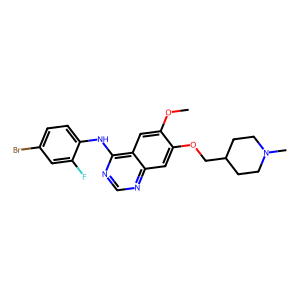

In [ ]:
#@title  Enter SMILES
d = input('Enter a chemical SMILES(length < 100): ').strip()
print(d)
from rdkit.Chem import Draw
from rdkit import Chem
mol = Chem.MolFromSmiles(d)

print("Length of the SMILES is " +str(len(d))+". The model may not perfom well on SMILES length more than 80.")
Draw.MolToImage(mol)

In [ ]:
#@title Predict Analogs
d_tensor,DrugIndex = load_dataset([d])
print(d_tensor)
d_latent = encoder.predict(d_tensor)
#@title
from rdkit.Chem.Draw import MolsToGridImage
from rdkit import Chem
from rdkit.Chem import Draw,MolToSmiles
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
##with open('gamma.pkl','rb') as f:
    #gamma = pickle.load(f)
def generator(num):
    mol = []
    for i in range(num):
        mu1 = 0 # mean and standard deviation
        seq_2 = np.random.normal(random.choice([-0.05,0.05]), random.choice([1,2]), 100)
        seq_2 = seq_2 + d_latent

        seq_2 = seq_2.reshape(1,100)
        y_train_pred = decoder.predict(seq_2)

        predicted_sec,pvalue = results(y_train_pred, maxlen)
        #predicted_sec
        mol.append(predicted_sec)
        #break
    return mol,pvalue


molecules,pvalue = generator(3000)


[[20 27 37  8 37 37  9 37  2 26 37 10 37 37 37  2 19 43  3 37 37 10 21  3
  41 37 41 37  9 37 37  8 27 20 20  8 20 20 26  2 20  3 20 20  8  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
print(d_latent)
print(molecules,pvalue)

[[ 3.83038330e+00 -2.16661835e+00  2.49399018e+00  2.36460376e+00
   2.83407402e+00  4.40921402e+00 -2.58458567e+00  7.25995636e+00
   2.55131698e+00 -6.89461136e+00 -2.57828045e+00  1.21268425e+01
  -3.20649338e+00 -2.87769127e+00  8.74137878e-03 -1.76677322e+00
  -1.95475388e+00 -2.09456635e+00  2.46945357e+00  9.00422668e+00
  -3.31873322e+00  7.07651329e+00 -3.24183083e+00  6.72342873e+00
  -1.03775845e+01 -5.34275818e+00  5.69327545e+00 -2.55699158e+00
  -4.44405365e+00 -1.06150055e+00  1.63836670e+00 -4.12824249e+00
   6.51578522e+00  6.65390015e+00  3.10045052e+00 -4.66945648e+00
  -2.51364899e+00 -1.26785507e+01  6.27966309e+00 -3.57599449e+00
   1.60445786e+00  4.32064056e+00  2.11739326e+00 -2.37525940e-01
  -1.29965401e+00 -2.65933418e+00 -5.69230270e+00  1.02657738e+01
  -9.07241058e+00  3.40068054e+00  5.11406326e+00  8.27814102e+00
  -7.17526245e+00 -4.87408066e+00 -3.48052788e+00  1.56705475e+00
  -2.41216040e+00  4.49481964e-01  3.68355179e+00 -5.68523407e-01
  -2.47181

In [ ]:
correct = []
correct_mol = []
molecules = set(molecules)
molecules = list(molecules)
#molecules = [i for i in molecules if len(i)<40]
for smi in molecules:
    try:
        mol = Chem.MolFromSmiles(smi)

        if mol is not None:
            correct_mol.append(smi)
            correct.append(mol)
    except:
        continue

MolsToGridImage(
    [m for m in correct  if m is not None], molsPerRow=5, subImgSize=(260, 160)
)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#@title List of Analogs SMILES
print(correct_mol)

['COc1cc2c(Nc3cnc(Br)cc3F)ncnc2cc1OCC1CCN(C)C1O', 'COc1cc2c(Nc3ccc(Br)cc3C)ncnc2cc1OCC1CCN(C)C1O', 'COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OC1NCCN(C)CC1', 'COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCCNC(N(C)CCl)O', 'COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OOC1CCN(C)C1O', 'COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1', 'COc1nc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)C1O', 'COc1cc2c(-c3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CO1', 'COc1cc2c(Nc3ccc(Br)cc3C)nccc2cc1OCC1CCN(C)CC1', 'COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OOC1CCN(C)OC1', 'COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1', 'COc1cc2c(Nc3ccc(Br)cc3F)nccc2cc1OCC1CCN(C)OC1', 'COc1cc2c(Nc3ccc(Br)cc3F)nccc2cc1OCC1CCN(C)CC1', 'COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCCOCCS(F)CCC', 'COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)c1O', 'COc1cc2c(Nc3ccc(Br)cc3C)ncnc2cc1OCC1CCN(C)OC1', 'CSc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OOC1CCN(C2CO2)N1C', 'COc1cc2c(Nc3ccc(Br)cc3C)ncnc2cc1OOC1CCN(C)CC1', 'COc1cc2c(Nc3ccc(Br)cc3F)ncnc2nc1OOC1CCN(C)CC1', 'CNc1cc2c(Nc3ccc(Br)cc3F)nnnc2cc1OCC1CCN(C)CC1', 'COc1cc2c(Nc3ccc(Br)cc3F)n

In [ ]:
#@title Total Number of Analogs Generated
len(correct_mol)

65